In [72]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns

ENTITY = "mosaic-ml"  # your wandb entity (user or team name)
PROJECT = "eval-llama2-callibrate"  # your project name

GROUPS = ["7", "13", "70"]

In [71]:
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 14.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 8.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [83]:
api = wandb.Api()
def extract_wandb_icl_data(entity,
                        project,
                        group):
    
    """ 
    Extract ICL data from the end of each run and combine into a pandas dataframe
    """
    runs = api.runs(f"{entity}/{project}", {"group": group})

    icl_df_list = []

    for i, run in enumerate(runs):
        if run.state == 'finished':
            print(run)
            print(run.name)
            print(run.group)            

            run_link = api.run(f"{entity}/{project}/{run.id}")
            data_list = run_link.logged_artifacts()


            idx = len(data_list) # this can sometimes be empty
            if idx > 0:
                
                data_dir = data_list[idx-1].download()
                print(data_dir)
                
                df = pd.read_parquet(f'{data_dir}/0000.parquet', engine='pyarrow') # this seems to be the format for data

                tmp_df = df.iloc[-1] # only select the last step, as this is the step when the model was evaluated in these runs
                tmp_df = tmp_df.to_frame().T # conver to single-row DataFrame
                tmp_df['run_name'] = run.name
                tmp_df['run_group'] = run.group
                icl_df_list.append(tmp_df)
                print(len(tmp_df))
            print('\n')
    if len(icl_df_list) == 0:
        return None
    
    icl_df = pd.concat(icl_df_list,ignore_index=True,axis=0)
    #icl_df.to_csv("wandb_group_metrics.csv", index=False)

    return icl_df

icl_df_groups = {group: extract_wandb_icl_data(ENTITY, PROJECT, group) for group in GROUPS}

<Run mosaic-ml/eval-llama2-callibrate/bc814veq (finished)>
eval-llama2-13-SDjghA
13


wandb:   1 of 1 files downloaded.  


/Users/tessa.barton/work/llm-foundry/scripts/eval/callibration/artifacts/run-bc814veq-history:v0
1


<Run mosaic-ml/eval-llama2-callibrate/fzh5qjql (finished)>
eval-llama2-13-KHLBCd
70


wandb:   1 of 1 files downloaded.  


/Users/tessa.barton/work/llm-foundry/scripts/eval/callibration/artifacts/run-fzh5qjql-history:v0
1




In [63]:
def process_df(df, group):
    if df is None:
        return None
    
    df['index1'] = df.index
    df = df.T
    df['index1'] = df.index

    def split_path_and_expand(row):
        # Split the 'path' column
        parts = row['index1'].split('/')
        if len(parts) == 5:
        # Assuming the structure is always the same and you want specific parts
            row['benchmark'] = parts[1]
            nshots = int(parts[2].split('-')[0])
            row['shots'] = nshots
            row['subtask'] = parts[3]
        elif len(parts) == 4:
            row['benchmark'] = parts[1]
            nshots = int(parts[2].split('-')[0])
            row['shots'] = nshots
            row['subtask'] = ''
        else:
            return np.nan
        return row

    # Apply the function to each row
    df = df.apply(split_path_and_expand, axis=1)
    df['variable'] = group
    df.drop('index1', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={0: 'accuracy'}, inplace=True)

    return df

icl_df_groups = [process_df(icl_df_groups[group], group) for group in GROUPS]

In [89]:
for i, g in icl_df_groups.items():
    if g is not None:
        print(len(g.columns))

26
470


In [64]:
icl_df_groups = [group for group in icl_df_groups if group is not None]
icl_df_groups = pd.concat(icl_df_groups, ignore_index=True)

In [65]:
icl_df_groups.head()

,accuracy,benchmark,shots,subtask,variable
0,0.697959,jeopardy,1.0,literature,13
1,0.342466,jeopardy,5.0,word_origins,13
2,0.397059,jeopardy,3.0,science,13
3,0.372654,jeopardy,0.0,world_history,13
4,0.656836,jeopardy,5.0,world_history,13


In [66]:
dfg = icl_df_groups.groupby(['shots', 'variable', 'benchmark'], as_index=False, dropna=False).accuracy.mean()


In [82]:
dfg[dfg['benchmark'] == 'jeopardy']

,shots,variable,benchmark,accuracy
0,0.0,13,jeopardy,0.268147
21,0.0,70,jeopardy,0.268147
34,1.0,13,jeopardy,0.515011
55,1.0,70,jeopardy,0.515011
68,3.0,13,jeopardy,0.528742
89,3.0,70,jeopardy,0.528742
102,5.0,13,jeopardy,0.540665
123,5.0,70,jeopardy,0.540665
136,10.0,13,jeopardy,0.593220
157,10.0,70,jeopardy,0.543048


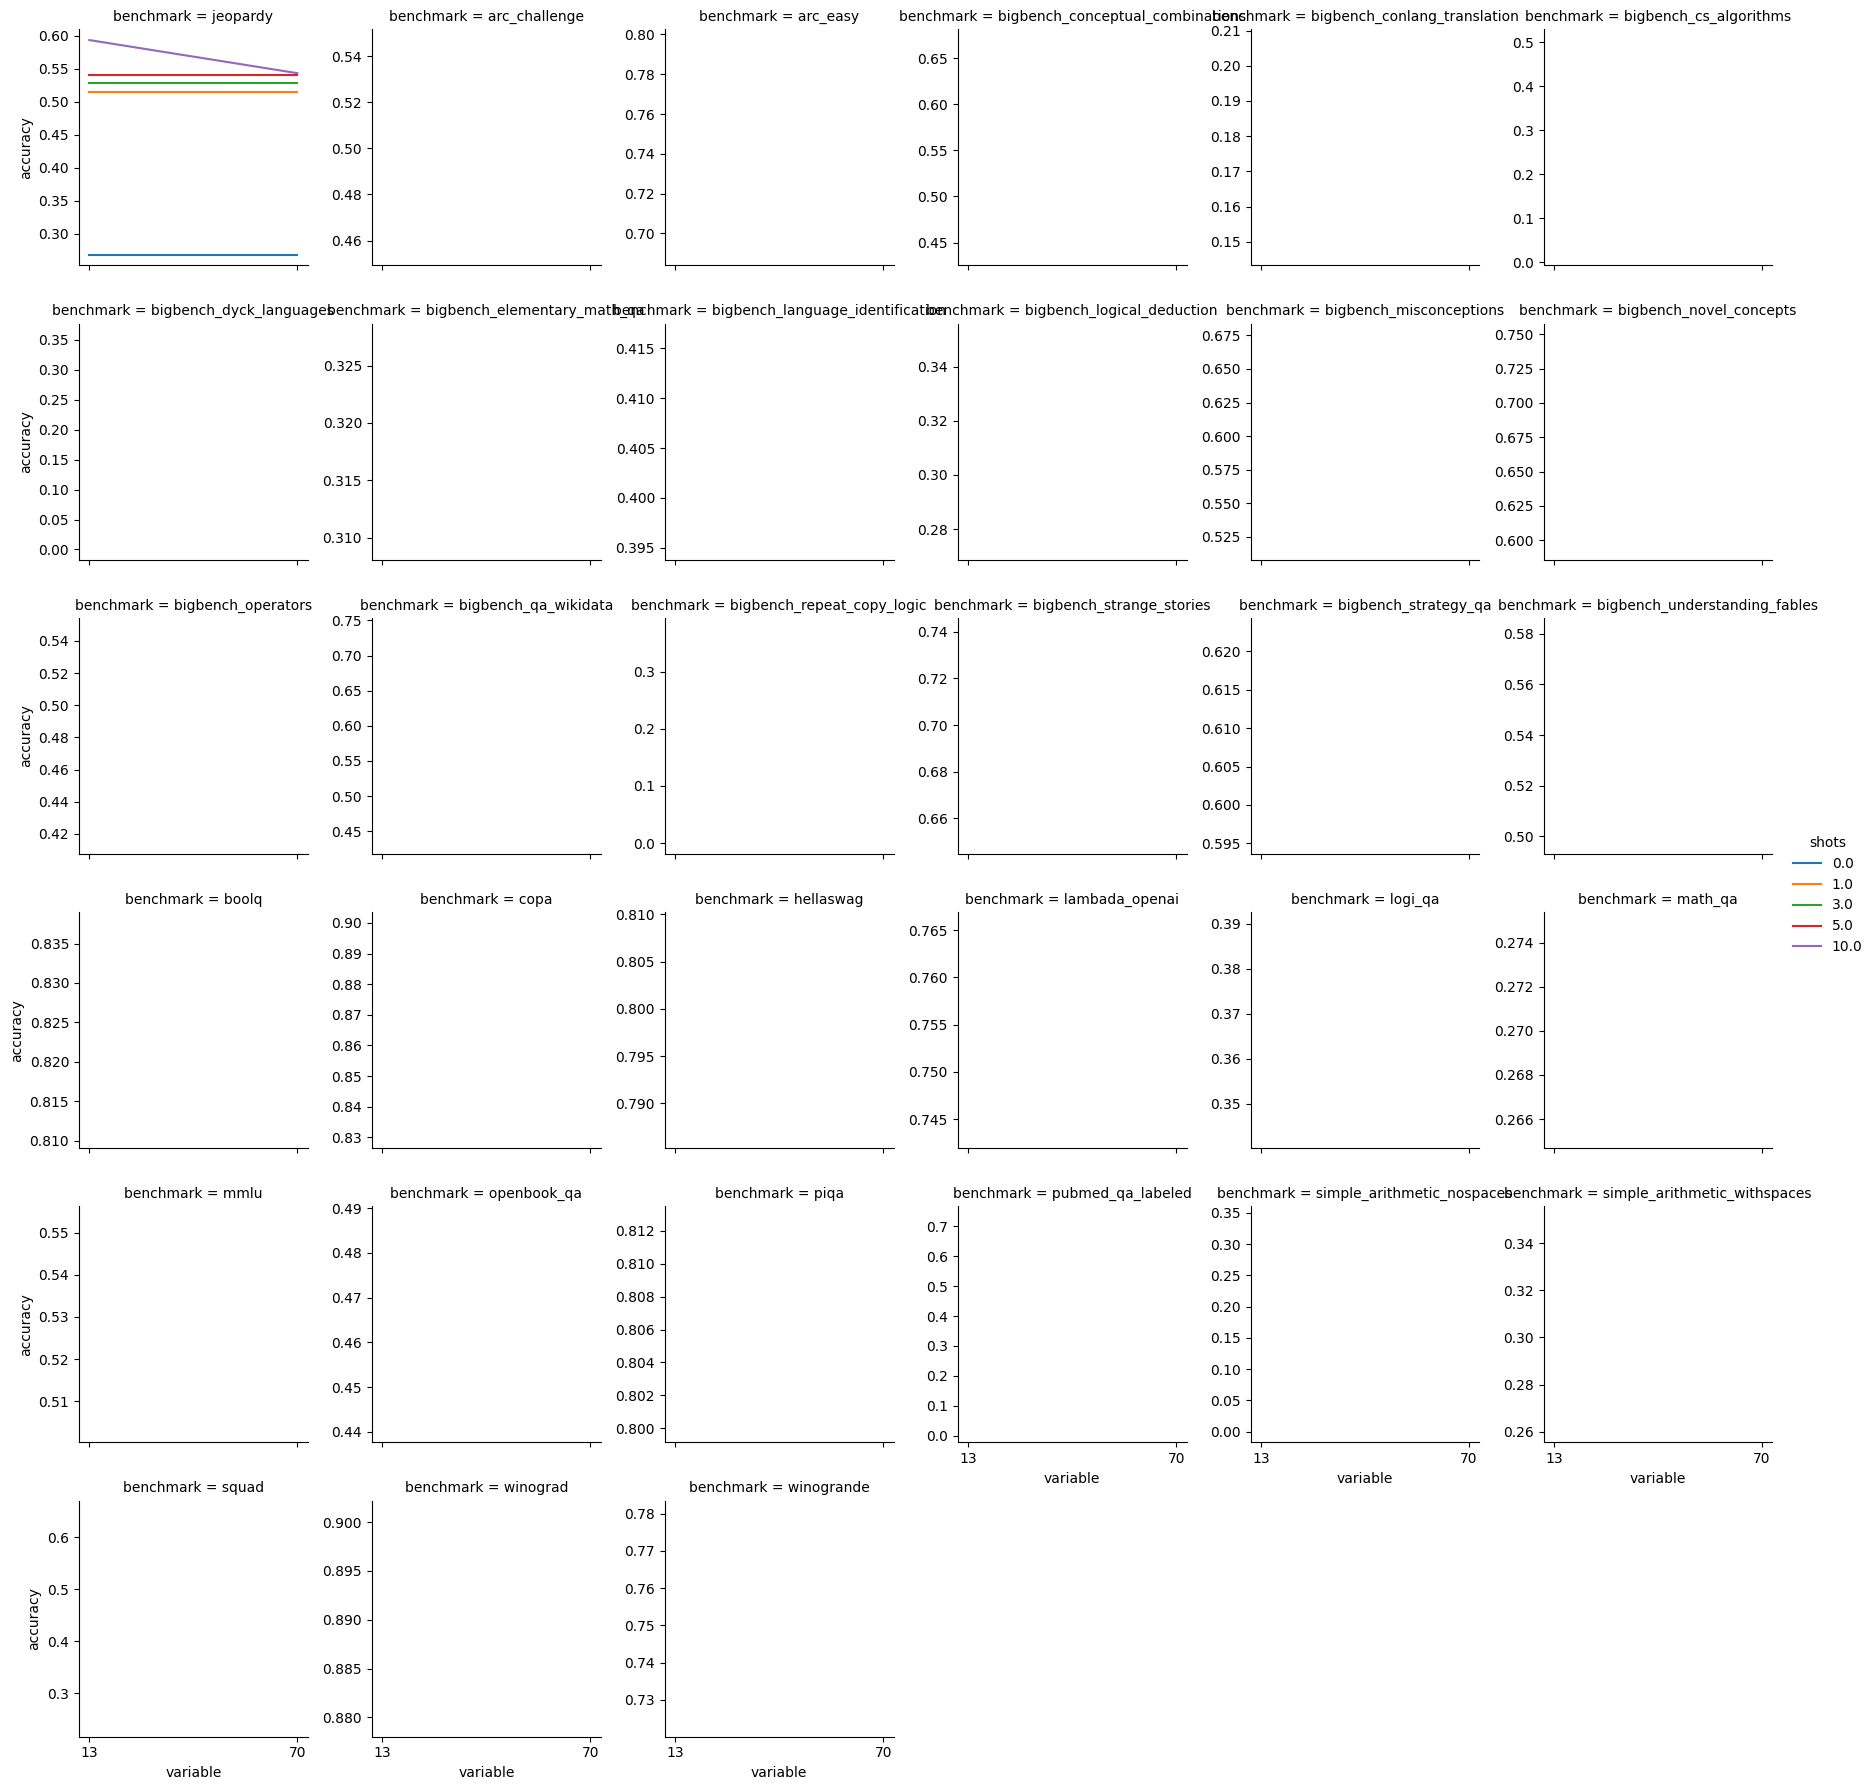

In [80]:
g = sns.relplot(
    data=dfg,
    y='accuracy',
    x='variable',
    hue='shots',
    col='benchmark',
    col_wrap=6,
    height=3,
    facet_kws=dict(sharey=False),
    kind='line',
    palette='tab10'
)